In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.cluster import KMeans

In [2]:
#Camera image
img = cv2.imread("s5.jpg")
#Marking tape template image
template = cv2.imread("template_green.jpg")

In [3]:
print(template.shape)
print(img.shape)

(42, 492, 3)
(4032, 3024, 3)


### Calculate mean RGB value for the template

In [4]:
mean = np.mean(template, axis=(0,1))
mean
#BGR in Open CV

array([ 57.86309524, 145.06450832, 111.30129694])

### Calculate Distance matrix for the camera image

In [5]:
#Euclidean
def dist_from_mean(x,mean):
    return np.linalg.norm(x - mean)

In [6]:
#mean - rgb mean of template
#2 - apply along color dimension
dist_img = np.apply_along_axis(dist_from_mean, 2 ,img, mean)

In [7]:
dist_img.shape

(4032, 3024)

## Create Threshold matrix by setting a threshold for distance matrix

In [8]:
#Thresholding - Only take thos pixels which have distance less than threshold to get a mask
DIST_THRESHOLD = 30
mask = np.where(dist_img < DIST_THRESHOLD, True, False)
mask.shape

(4032, 3024)

## Plotting the threshold matrix along with the real image to see if edge detection works properly. Adjust DIST_THRESHOLD accordingly.

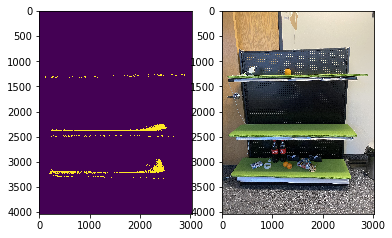

In [9]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(mask)
f.add_subplot(1,2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show(block=True)

## Extract coordinates of the edge points from the threshold matrix (mask)

In [10]:
all_edge_coordinates = np.argwhere(mask==True)
all_edge_coordinates.shape

(215185, 2)

In [11]:
#k-means give initial centres - not required now
# x,y = np.nonzero(mask)
# data = np.nonzero(mask)
# print(x,y)

# print(min(x), max(x))
# print(min(y), max(y))


# k=3
# center_y = (min(y) +max(y))/2
# # print(center_y)

# center_x1 = min(x)
# center_x2 = (min(x)+max(x))/2
# center_x3 = max(x)

# init_centres = np.array([[1200,1500],[2300,1500],[3200,1500]])
# print(init_centres.shape)

# kmeans = KMeans(n_clusters=3, random_state=0, init=init_centres).fit(coord_data)

In [12]:
init_centres = np.array([[1200,1500],[2300,1500],[3200,1500]])

## K-Means Clustering (K = number of edges in image)

In [15]:
num_of_edges_in_camera_view = 3

In [16]:
feature_wt = 2
# init_centers
scaled_all_edge_coordinates = all_edge_coordinates.copy()
scaled_all_edge_coordinates[:,0] = scaled_all_edge_coordinates[:,0]*feature_wt
kmeans = KMeans(n_clusters=num_of_edges_in_camera_view, random_state=0, init =init_centres ).fit(scaled_all_edge_coordinates)
labels = kmeans.labels_

C:\Users\ivc17297adm\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [17]:
all_edge_coordinates[np.where(labels==2)]

array([[2246, 2424],
       [2246, 2425],
       [2247, 2437],
       ...,
       [2498, 2641],
       [2498, 2642],
       [2498, 2643]], dtype=int64)

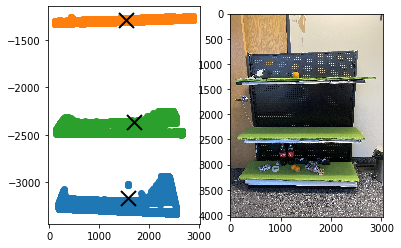

In [18]:
import matplotlib.pyplot as plt

k = num_of_edges_in_camera_view
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#For plotting
f = plt.figure()
f.add_subplot(1,2,1)

for i in range(k):
        # select only data observations with cluster label == i
        ds = all_edge_coordinates[np.where(labels==i)]
        # plot the data observations
        plt.plot(ds[:,1],-ds[:,0],'o')
        lines = pyplot.plot(centroids[i,1],-centroids[i,0]/feature_wt,'kx')
        # make the centroid x's bigger
        plt.setp(lines,ms=15.0)
        plt.setp(lines,mew=2.0)
        
f.add_subplot(1,2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show(block=True)

## Extract Cluster points

In [19]:
all_cluster_data_points = []
for i in range(num_of_edges_in_camera_view):
    all_cluster_data_points.append(all_edge_coordinates[np.where(labels==i)])

print(len(all_cluster_data_points))
print("Points for Cluster 1")
print(all_cluster_data_points[0])

3
Points for Cluster 1
[[2937 2238]
 [2937 2239]
 [2937 2240]
 ...
 [3336 2522]
 [3336 2523]
 [3336 2527]]


## Apply Regression on the cluster points to get edge information

Slope =  -5.6102501585503335 Intercept =  19370.989573044466
Min y =  176 Max y =  2551
Slope =  -35.19320868991298 Intercept =  47006.395960282505
Min y =  110 Max y =  2887
Slope =  -6.025169192912331 Intercept =  15946.700812090336
Min y =  126 Max y =  2671


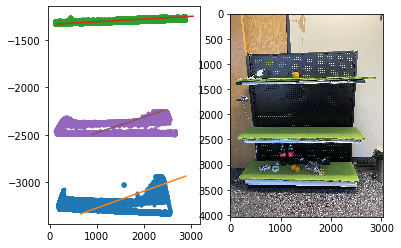

In [20]:
from numpy.polynomial.polynomial import polyfit

all_edges = []

#For plotting
f = plt.figure()
f.add_subplot(1,2, 1)


#b - Intercept, m - Slope
for i, cluster_i_data_points in enumerate(all_cluster_data_points):
    x = cluster_i_data_points[:,0]
    y = cluster_i_data_points[:,1]
    min_y = min(y)
    max_y = max(y)
    b, m = polyfit(x, y, 1)
    print("Slope = ", m, "Intercept = ", b)
    print("Min y = ", min_y, "Max y = ", max_y)
    edge = {"Intercept":b,"Slope":m,"min_y":min_y,"max_y":max_y}
    #Add this edge to the list of edges
    all_edges.append(edge)
    #Plotting the edges to check if the line is fit correctly
    #Plot points
    plt.plot(y, -x, '.')
    #Plot Line
    plt.plot(b + m * x, -x, '-')
    
f.add_subplot(1,2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show(block=True)

## Function: check_point_location_wrt_edge

In [26]:
def chk_pt_loc_wrt_edge(edge,x,y):
    min_y = edge["min_y"]
    max_y = edge["max_y"]
    b = edge["Intercept"]
    m = edge["Slope"]
    
    if(y < min_y or y > max_y):
        return "Out of edge boundary"
    
    y_edge = m*x + b
    
    if(y_edge>=0):
        return "Above Edge"
        return 1
    else:
        return "Below Edge"
        return 0

In [25]:
#Edge 0 is the bottom one, Edge 2 is the top one in this scenario
chk_pt_loc_wrt_edge(all_edges[0],2000,2800)

'Out of edge boundary'